**Task 2**

In [363]:
from google.colab import drive
import numpy as np
import pandas as pd
import os
import glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from torchviz import make_dot
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

Check Cuda Availability

In [364]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Mount google drive

In [365]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define data path

In [366]:
class_priority_path = '/content/drive/My Drive/data/Priority'
class_stop_path = '/content/drive/My Drive/data/Stop'

In [367]:
priority_images = [image for image in os.listdir(class_priority_path) if image.endswith('.jpg')]
stop_images = [image for image in os.listdir(class_stop_path) if image.endswith('.jpg')]
labeled_stop_images_full_path = [(os.path.join(class_stop_path, image), 0) for image in stop_images]
labeled_priority_images_full_path = [(os.path.join(class_priority_path, image), 1) for image in priority_images]
data = labeled_priority_images_full_path + labeled_stop_images_full_path

Load Data to x and y (features and label)

In [368]:
X_array = []
y_array = []

for item in data:
  x_image = cv2.imread(item[0])
  x_image = cv2.resize(x_image, (224, 224))
  X_array.append(x_image)
  y_image = item[1]
  y_array.append(y_image)

X_array = np.array(X_array)
y_array = np.array(y_array)

Data Augmentation

In [369]:
def data_augmentation(image):

  if np.random.rand(1) > 0.5:
      image = cv2.flip(image, 1)

  if np.random.rand(1) > 0.5:
      angle = np.random.randint(-15, 15)
      M = cv2.getRotationMatrix2D((112, 112), angle, 1)
      image = cv2.warpAffine(image, M, (224, 224))

  if np.random.rand(1) > 0.5:
      zoom_factor = np.random.uniform(0.9, 1.1)
      new_size = int(224 * zoom_factor)
      image = cv2.resize(image, (new_size, new_size))
      if zoom_factor < 1:
          pad = (224 - new_size) // 2
          image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
      else:
          crop = (new_size - 224) // 2
          image = image[crop:crop+224, crop:crop+224]

  if np.random.rand(1) > 0.5:
      tx = np.random.randint(-10, 10)
      ty = np.random.randint(-10, 10)
      M = np.float32([[1, 0, tx], [0, 1, ty]])
      image = cv2.warpAffine(image, M, (224, 224))

  if np.random.rand(1) > 0.5:
      value = np.random.randint(-30, 30)
      hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
      h, s, v = cv2.split(hsv)
      v = cv2.add(v, value)
      v[v > 255] = 255
      v[v < 0] = 0
      final_hsv = cv2.merge((h, s, v))
      image = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

  image = cv2.resize(image, (224, 224))

  return image

In [370]:
augmented_images = []
augmented_labels = []

augmentation_factor = 5

for img, label in zip(X_array, y_array):
  for _ in range(augmentation_factor):
    augmented_image = data_augmentation(img)
    augmented_images.append(augmented_image)
    augmented_labels.append(label)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)
unique_labels, label_counts = np.unique(augmented_labels, return_counts=True)
min_samples_per_class = np.min(label_counts)

balanced_augmented_images = []
balanced_augmented_labels = []
for label in unique_labels:
  class_indices = np.where(augmented_labels == label)[0]
  class_images = augmented_images[class_indices]
  class_labels = augmented_labels[class_indices]

  selected_indices = np.random.choice(len(class_images), min_samples_per_class, replace=False)
  balanced_augmented_images.extend(class_images[selected_indices])
  balanced_augmented_labels.extend(class_labels[selected_indices])

balanced_augmented_images = np.array(balanced_augmented_images)
balanced_augmented_labels = np.array(balanced_augmented_labels)

unique_labels_balanced, counts_balanced = np.unique(balanced_augmented_labels, return_counts=True)
for label, count in zip(unique_labels_balanced, counts_balanced):
  print(f"Label {label}: {count} samples")

Label 0: 765 samples
Label 1: 765 samples


In [371]:
X = balanced_augmented_images
y = balanced_augmented_labels

print("Original number of images:", len(X_array))
print("Augmented number of images:", len(X))

Original number of images: 378
Augmented number of images: 1530


Convert to Tensor

In [372]:
X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
y = torch.tensor(y, dtype=torch.long)

Train-Test Split

In [373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

Load ResNet18

In [374]:
baseModel = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Create Model

In [375]:
baseModel.fc = nn.Sequential(nn.Linear(512, 256), nn.Dropout(p=0.5), nn.Linear(256, 1))
model_resnet18_classification = baseModel

Train Data

In [376]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, test_size=0.1, random_state=42)

epochs = 50
batch_size = 16
loss_function = nn.BCEWithLogitsLoss()
num_batches_train = (len(X_train) + batch_size - 1) // batch_size
num_batches_val = (len(X_val) + batch_size - 1) // batch_size

optimizer = optim.Adam(model_resnet18_classification.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

train_losses = []
val_losses = []

for epoch in range(epochs):

  model_resnet18_classification.train().to(device)
  train_loss = 0

  for i in range(num_batches_train):
    batch_inputs = X_train[i * batch_size:(i + 1) * batch_size]
    batch_labels = y_train[i * batch_size:(i + 1) * batch_size].unsqueeze(1).float().to(device)

    optimizer.zero_grad()
    outputs = model_resnet18_classification(batch_inputs)
    loss = loss_function(outputs, batch_labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  epoch_train_loss = train_loss / num_batches_train
  train_losses.append(epoch_train_loss)

  model_resnet18_classification.eval().to(device)
  val_loss = 0
  all_labels = []
  all_outputs = []

  with torch.no_grad():
    for j in range(num_batches_val):
      batch_inputs = X_val[j * batch_size:(j + 1) * batch_size]
      batch_labels = y_val[j * batch_size:(j + 1) * batch_size].unsqueeze(1).float().to(device)

      outputs = model_resnet18_classification(batch_inputs)
      loss = loss_function(outputs, batch_labels)
      val_loss += loss.item()
      all_labels.extend(batch_labels.cpu().numpy())
      all_outputs.extend(outputs.cpu().numpy().argmax(axis=1))

    epoch_val_loss = val_loss / num_batches_val
    val_losses.append(epoch_val_loss)
    scheduler.step(val_loss)

  epoch_train_loss = train_loss / num_batches_train

  print(f'epoch {epoch+1} Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


epoch 1 Train Loss: 7.773089, Val Loss: 0.017604
epoch 2 Train Loss: 2.911221, Val Loss: 0.051411
epoch 3 Train Loss: 2.885206, Val Loss: 0.044972
epoch 4 Train Loss: 0.352479, Val Loss: 0.009928
epoch 5 Train Loss: 0.735974, Val Loss: 0.000264
epoch 6 Train Loss: 0.007934, Val Loss: 0.000184
epoch 7 Train Loss: 0.005084, Val Loss: 0.000153
epoch 8 Train Loss: 0.003828, Val Loss: 0.000122
epoch 9 Train Loss: 0.003018, Val Loss: 0.000108
epoch 10 Train Loss: 0.002515, Val Loss: 0.000094
epoch 11 Train Loss: 0.001912, Val Loss: 0.000086
epoch 12 Train Loss: 0.002021, Val Loss: 0.000079
epoch 13 Train Loss: 0.001480, Val Loss: 0.000069
epoch 14 Train Loss: 0.001302, Val Loss: 0.000059
epoch 15 Train Loss: 0.001574, Val Loss: 0.000040
epoch 16 Train Loss: 0.001212, Val Loss: 0.000036
epoch 17 Train Loss: 0.001002, Val Loss: 0.000034
epoch 18 Train Loss: 0.000797, Val Loss: 0.000033
epoch 19 Train Loss: 0.000746, Val Loss: 0.000030
epoch 20 Train Loss: 0.000785, Val Loss: 0.000029
epoch 21 

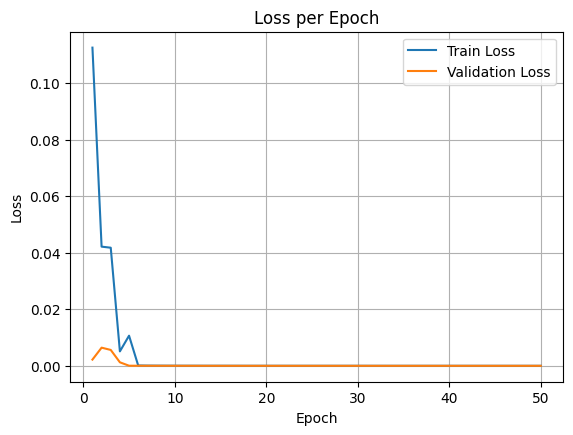

In [377]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

Save Model

In [378]:
torch.save(model_resnet18_classification.state_dict(), 'model_resnet18_classification.pth')

Load Model

In [379]:
baseModel = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
baseModel.fc = nn.Sequential(nn.Linear(512, 256), nn.Dropout(p=0.5), nn.Linear(256, 1))
model_resnet18_classification = baseModel
model_resnet18_classification = model_resnet18_classification.to(device).eval()
model_resnet18_classification.load_state_dict(torch.load('model_resnet18_classification.pth'))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

Model Evaluation

In [380]:
model_resnet18_classification.eval().to(device)

num_batches_test = (len(X_test) + batch_size - 1) // batch_size
actuals = []
predictions = []

with torch.no_grad():
  for i in range(num_batches_test):
    batch_inputs_test = X_test[i * batch_size:(i + 1) * batch_size]
    batch_labels_test = y_test[i * batch_size:(i + 1) * batch_size].unsqueeze(1).float().to(device)

    outputs = model_resnet18_classification(batch_inputs_test)
    probabilities = torch.sigmoid(outputs)
    predicted_labels = (probabilities > 0.5).float()

    actuals.extend(batch_labels_test.cpu().numpy())
    predictions.extend(predicted_labels.cpu().numpy())

actuals = np.array(actuals)
predictions = np.array(predictions)

accuracy = accuracy_score(actuals, predictions)
precision = precision_score(actuals, predictions, average='binary')
recall = recall_score(actuals, predictions, average='binary')
f1 = f1_score(actuals, predictions, average='binary')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.9967320261437909
Precision: 0.9938650306748467
Recall: 1.0
F1 Score: 0.9969230769230769


Test on Input Image

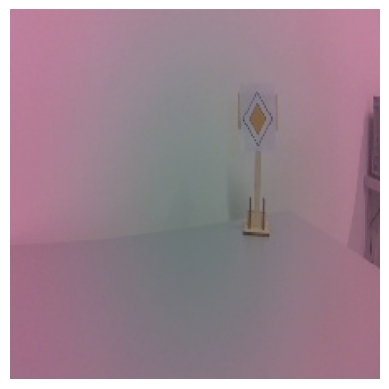

Predicted Class:  class 1: Priority


In [382]:
image_path = '/content/Test.jpg'

class_names = ['class 0: Stop', 'class 1: Priority']

image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
image = image.unsqueeze(0)
image /= 255.0

model_resnet18_classification.eval().to(device)
with torch.no_grad():
  outputs = model_resnet18_classification(image.to(device))
  predicted_prob = torch.sigmoid(outputs).item()

if predicted_prob >= 0.5:
  class_name = class_names[1]
else:
  class_name = class_names[0]

plt.imshow(image.squeeze(0).permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

print('Predicted Class: ', class_name)